Repo root and output folder

In [7]:
import os
from pathlib import Path

HERE = Path.cwd()
if HERE.name == "notebooks":
    os.chdir(HERE.parent)

print("CWD:", Path.cwd())

OUT_DIR = Path("outputs/figures/03_graphs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", OUT_DIR.resolve())


CWD: /Users/samyuktareddy/Desktop/MOF Gas absorption
Saving to: /Users/samyuktareddy/Desktop/MOF Gas absorption/outputs/figures/03_graphs


Load coverage + connectivity audit tables

In [8]:
import pandas as pd
from pathlib import Path

COV_PATH = Path("data/processed/labeled_coverage_by_threshold.csv")
CONN_PATH = Path("outputs/split_connectivity_audit.csv")

if not COV_PATH.exists():
    raise FileNotFoundError(f"Missing {COV_PATH}.")
if not CONN_PATH.exists():
    raise FileNotFoundError(f"Missing {CONN_PATH}. Run audit_split_connectivity.py first.")

cov = pd.read_csv(COV_PATH)
conn = pd.read_csv(CONN_PATH)

print("Coverage rows:", len(cov), "Columns:", list(cov.columns))
print("Connectivity rows:", len(conn), "Columns:", list(conn.columns))

cov.head()


Coverage rows: 12 Columns: ['threshold', 'run', 'graph_nodes', 'graph_edges', 'labeled_total', 'labeled_in_graph', 'train_labeled_in_graph', 'val_labeled_in_graph', 'test_labeled_in_graph']
Connectivity rows: 12 Columns: ['threshold', 'run', 'test_nodes_total', 'test_nodes_with_train_neighbor', 'pct_test_with_train_neighbor', 'mean_max_weight_test_to_train', 'edges']


,threshold,run,graph_nodes,graph_edges,labeled_total,labeled_in_graph,train_labeled_in_graph,val_labeled_in_graph,test_labeled_in_graph
0,threshold_0.00,run_0,11073,195379,363,307,216,42,49
1,threshold_0.00,run_1,11164,196714,363,311,218,43,50
2,threshold_0.00,run_2,11060,195559,363,311,218,43,50
3,threshold_0.00,run_3,11055,195180,363,313,219,44,50
4,threshold_0.10,run_0,9943,164272,363,271,187,38,46


Clean threshold numeric and aggregate across runs

In [9]:
import re
import numpy as np

def thr_to_float(s: str) -> float:
    # "threshold_0.10" -> 0.10
    m = re.search(r"threshold_(\d+\.\d+|\d+)", str(s))
    return float(m.group(1)) if m else np.nan

cov["thr"] = cov["threshold"].apply(thr_to_float)
conn["thr"] = conn["threshold"].apply(thr_to_float)

# Ensure numeric types
conn["pct_test_with_train_neighbor"] = pd.to_numeric(conn["pct_test_with_train_neighbor"], errors="coerce")
conn["mean_max_weight_test_to_train"] = pd.to_numeric(conn["mean_max_weight_test_to_train"], errors="coerce")

# For convenience in plotting
conn["exposure_pct"] = conn["pct_test_with_train_neighbor"]

cov[["threshold","run","thr","labeled_in_graph","graph_nodes","graph_edges"]].head()

,threshold,run,thr,labeled_in_graph,graph_nodes,graph_edges
0,threshold_0.00,run_0,0.0,307,11073,195379
1,threshold_0.00,run_1,0.0,311,11164,196714
2,threshold_0.00,run_2,0.0,311,11060,195559
3,threshold_0.00,run_3,0.0,313,11055,195180
4,threshold_0.10,run_0,0.1,271,9943,164272


Aggregate across runs (mean ± std)

In [10]:
cov_agg = cov.groupby("thr").agg(
    labeled_in_graph_mean=("labeled_in_graph", "mean"),
    labeled_in_graph_std=("labeled_in_graph", "std"),
    graph_nodes_mean=("graph_nodes", "mean"),
    graph_nodes_std=("graph_nodes", "std"),
    graph_edges_mean=("graph_edges", "mean"),
    graph_edges_std=("graph_edges", "std"),
).reset_index().sort_values("thr")

conn_agg = conn.groupby("thr").agg(
    exposure_pct_mean=("exposure_pct", "mean"),
    exposure_pct_std=("exposure_pct", "std"),
    mean_max_w_mean=("mean_max_weight_test_to_train", "mean"),
    mean_max_w_std=("mean_max_weight_test_to_train", "std"),
).reset_index().sort_values("thr")

print("Coverage aggregated:")
display(cov_agg)

print("Connectivity aggregated:")
display(conn_agg)


Coverage aggregated:


,thr,labeled_in_graph_mean,labeled_in_graph_std,graph_nodes_mean,graph_nodes_std,graph_edges_mean,graph_edges_std
0,0.0,310.50,2.516611,11088.0,51.231501,195708.00,688.297901
1,0.1,273.25,2.872281,9963.5,57.017541,164639.75,739.755534
2,0.9,37.75,1.258306,1228.0,25.429641,1206.75,14.637281


Connectivity aggregated:


,thr,exposure_pct_mean,exposure_pct_std,mean_max_w_mean,mean_max_w_std
0,0.0,72.7300,0.000000,0.957525,0.002554
1,0.1,67.7275,2.725000,0.953625,0.001226
2,0.9,0.9100,1.050777,0.500000,0.577350


FIGURE 1: Label coverage vs threshold (mean ± std)

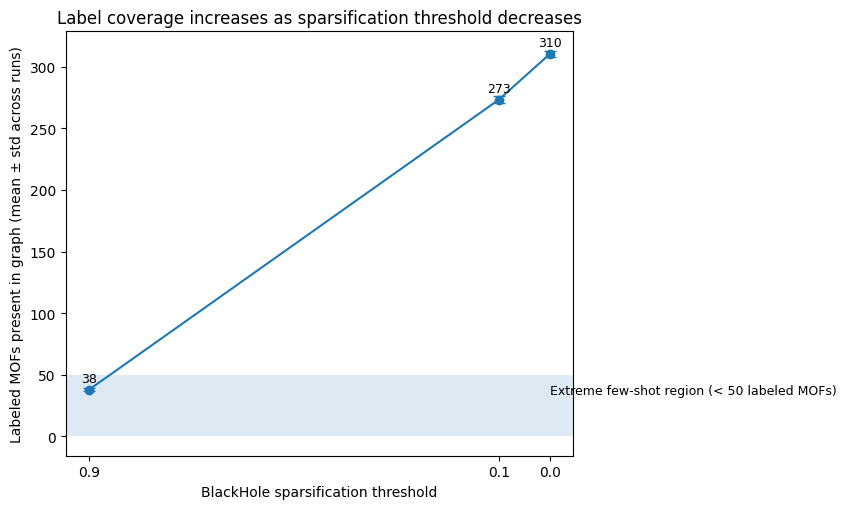

Saved: outputs/figures/03_graphs/coverage_vs_threshold_v2_inverted_axis.png


In [16]:
import matplotlib.pyplot as plt

x = cov_agg["thr"].values
y = cov_agg["labeled_in_graph_mean"].values
yerr = cov_agg["labeled_in_graph_std"].fillna(0).values

plt.figure(figsize=(8.5, 5.2))

# few-shot reference region (adjust 50 if you want a different cutoff)
fewshot_cutoff = 50
plt.axhspan(0, fewshot_cutoff, alpha=0.15)
plt.text(
    x.min(), fewshot_cutoff * 0.85,
    f"Extreme few-shot region (< {fewshot_cutoff} labeled MOFs)",
    fontsize=9, va="top"
)

plt.errorbar(
    x, y, yerr=yerr,
    fmt="o-", capsize=4
)

# Label each point (mean value)
for xi, yi in zip(x, y):
    plt.text(xi, yi + max(y)*0.02, f"{int(round(yi))}", ha="center", fontsize=9)

plt.xlabel("BlackHole sparsification threshold")
plt.ylabel("Labeled MOFs present in graph (mean ± std across runs)")
plt.title("Label coverage increases as sparsification threshold decreases")

# Key fix: invert x-axis so "threshold decreases" reads left→right
plt.gca().invert_xaxis()

# Optional: make x ticks show the thresholds clearly (works even if you have many thresholds)
plt.xticks(sorted(x, reverse=True))

out = OUT_DIR / "coverage_vs_threshold_v2_inverted_axis.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()

print("Saved:", out)


FIGURE 2: Graph size vs threshold (nodes + edges)

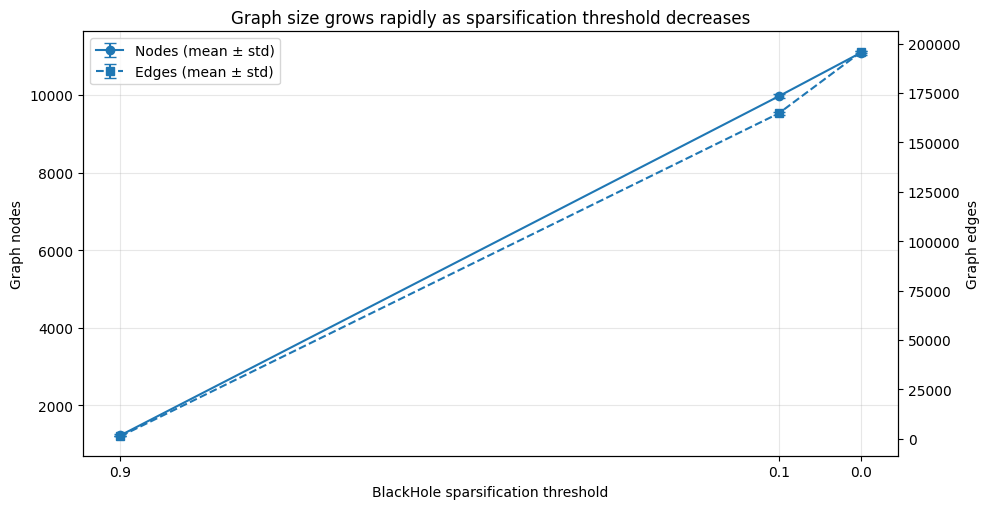

Saved: outputs/figures/03_graphs/graph_size_vs_threshold_v2_inverted_axis.png


In [19]:
import matplotlib.pyplot as plt

# --- FIGURE 2 (fixed): Graph size grows as threshold decreases ---
# Assumes cov_agg has:
# thr, graph_nodes_mean, graph_nodes_std, graph_edges_mean, graph_edges_std

x = cov_agg["thr"].values

nodes_mean = cov_agg["graph_nodes_mean"].values
nodes_std  = cov_agg["graph_nodes_std"].fillna(0).values

edges_mean = cov_agg["graph_edges_mean"].values
edges_std  = cov_agg["graph_edges_std"].fillna(0).values

fig = plt.figure(figsize=(10, 5.2))
ax = fig.add_subplot(111)

# Nodes (left axis)
ax.errorbar(
    x, nodes_mean, yerr=nodes_std,
    fmt="o-", capsize=4, label="Nodes (mean ± std)"
)
ax.set_xlabel("BlackHole sparsification threshold")
ax.set_ylabel("Graph nodes")
ax.set_title("Graph size grows rapidly as sparsification threshold decreases")
ax.grid(True, alpha=0.3)

# Edges (right axis)
ax2 = ax.twinx()
ax2.errorbar(
    x, edges_mean, yerr=edges_std,
    fmt="s--", capsize=4, label="Edges (mean ± std)"
)
ax2.set_ylabel("Graph edges")

# ✅ Key fix: make “threshold decreases” read left → right
ax.invert_xaxis()

# Nice, consistent ticks (e.g., [0.90, 0.10, 0.00] depending on your data)
ax.set_xticks(sorted(x, reverse=True))

# Combined legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

out = OUT_DIR / "graph_size_vs_threshold_v2_inverted_axis.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)

Lower thresholds retain more nodes and edges, producing a denser graph. This increases message-passing opportunities but also raises compute cost and the risk of cross-split connectivity.

FIGURE 3: Leakage proxy — test→train exposure % vs threshold

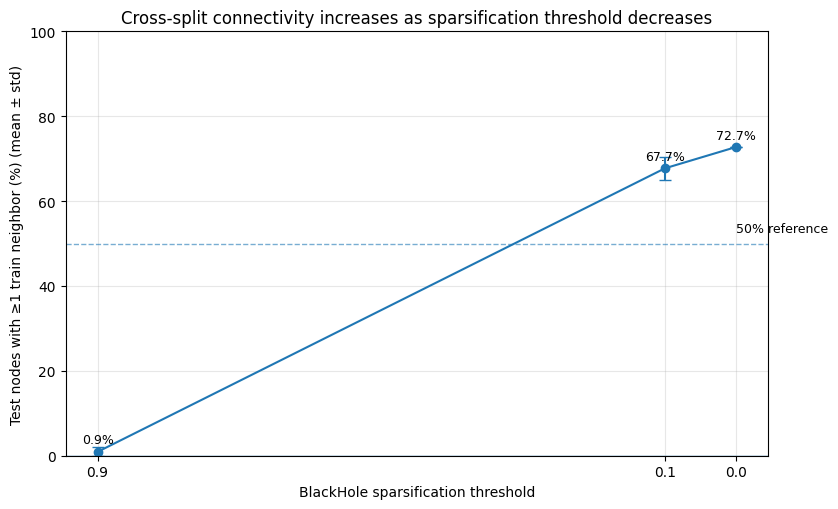

Saved: outputs/figures/03_graphs/exposure_vs_threshold_v2_inverted_axis.png


In [20]:
import matplotlib.pyplot as plt

# --- FIGURE 3 (fixed): Leakage proxy / connectivity across splits ---
# Assumes conn_agg has:
# thr, exposure_pct_mean, exposure_pct_std

x = conn_agg["thr"].values
y = conn_agg["exposure_pct_mean"].values
yerr = conn_agg["exposure_pct_std"].fillna(0).values

plt.figure(figsize=(8.5, 5.2))

# Reference lines (helpful for interpretation)
plt.axhline(0, linewidth=1)
plt.axhline(50, linestyle="--", linewidth=1, alpha=0.6)
plt.text(x.min(), 52, "50% reference", fontsize=9, va="bottom")

plt.errorbar(
    x, y, yerr=yerr,
    fmt="o-", capsize=4
)

# Label each point
for xi, yi in zip(x, y):
    plt.text(xi, yi + 2, f"{yi:.1f}%", ha="center", fontsize=9)

plt.xlabel("BlackHole sparsification threshold")
plt.ylabel("Test nodes with ≥1 train neighbor (%) (mean ± std)")
plt.title("Cross-split connectivity increases as sparsification threshold decreases")
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

# ✅ Key fix: make “threshold decreases” read left → right
plt.gca().invert_xaxis()
plt.xticks(sorted(x, reverse=True))

out = OUT_DIR / "exposure_vs_threshold_v2_inverted_axis.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)


As the threshold decreases, many more test nodes become directly connected to training nodes, which increases message passing but also raises leakage/oversmoothing concerns.

FIGURE 4: mean max similarity weight test→train vs threshold

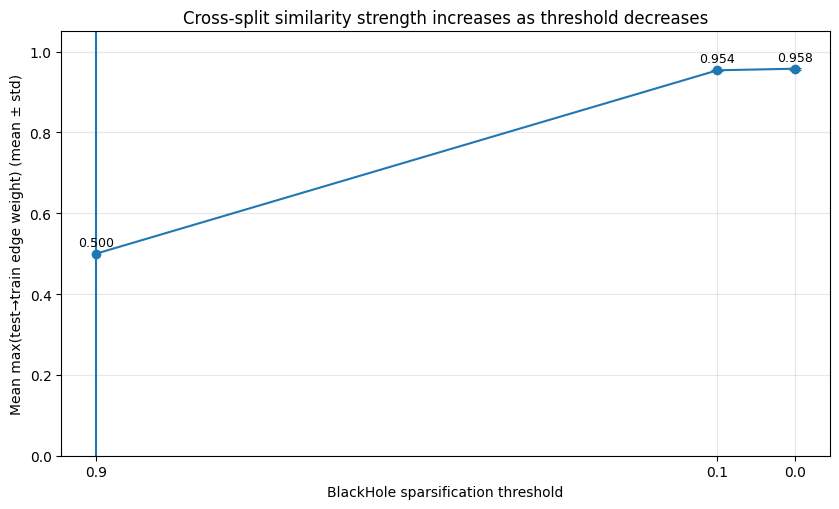

Saved: outputs/figures/03_graphs/mean_max_weight_vs_threshold_v2_inverted_axis.png


In [21]:
import matplotlib.pyplot as plt

# --- FIGURE 4 (fixed): Similarity strength across split boundary ---
# Assumes conn_agg has:
# thr, mean_max_w_mean, mean_max_w_std

x = conn_agg["thr"].values
y = conn_agg["mean_max_w_mean"].values
yerr = conn_agg["mean_max_w_std"].fillna(0).values

plt.figure(figsize=(8.5, 5.2))

plt.errorbar(
    x, y, yerr=yerr,
    fmt="o-", capsize=4
)

# Label points
for xi, yi in zip(x, y):
    plt.text(xi, yi + 0.02, f"{yi:.3f}", ha="center", fontsize=9)

plt.xlabel("BlackHole sparsification threshold")
plt.ylabel("Mean max(test→train edge weight) (mean ± std)")
plt.title("Cross-split similarity strength increases as threshold decreases")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)

# ✅ Key fix: make “threshold decreases” read left → right
plt.gca().invert_xaxis()
plt.xticks(sorted(x, reverse=True))

out = OUT_DIR / "mean_max_weight_vs_threshold_v2_inverted_axis.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)


Lower thresholds not only increase connectivity, they also increase the strength of similarity links from test to train, explaining why dense graphs can change observed performance.

FIGURE 5:Per-run coverage lines (showing robustness)

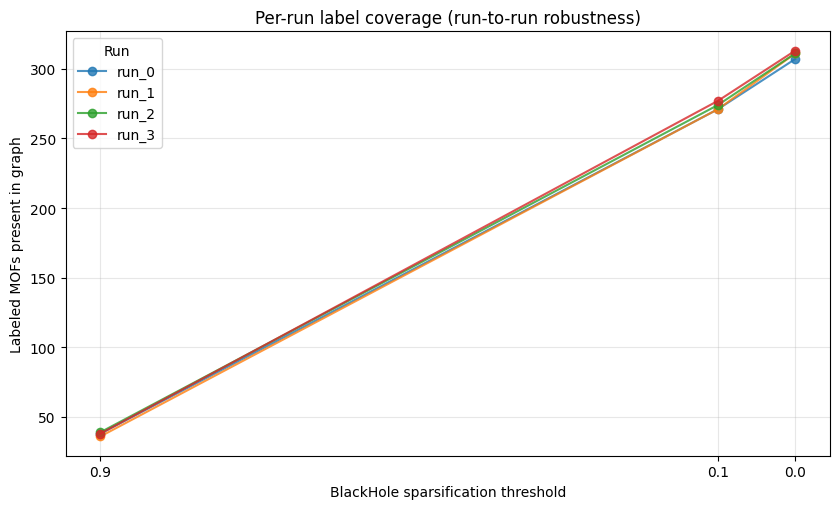

Saved: outputs/figures/03_graphs/coverage_per_run_v2_inverted_axis.png


In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8.5, 5.2))

for run, sub in cov.groupby("run"):
    sub = sub.sort_values("thr")
    plt.plot(
        sub["thr"],
        sub["labeled_in_graph"],
        marker="o",
        linestyle="-",
        alpha=0.8,
        label=str(run)
    )

plt.xlabel("BlackHole sparsification threshold")
plt.ylabel("Labeled MOFs present in graph")
plt.title("Per-run label coverage (run-to-run robustness)")
plt.grid(True, alpha=0.3)

# ✅ Key fix: make “threshold decreases” read left → right
plt.gca().invert_xaxis()

# Consistent ticks
ticks = sorted(cov["thr"].unique(), reverse=True)
plt.xticks(ticks)

plt.legend(title="Run", loc="best")

out = OUT_DIR / "coverage_per_run_v2_inverted_axis.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)


Across different BlackHole runs, the same trend holds, so coverage results are robust and not driven by a single random graph realization.